In [1]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setting

In [2]:
import torch
## Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


# Preprocessing

In [38]:
## Preprocessing
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load input file
input_filepath = '/content/drive/MyDrive/Colab Notebooks/koi_project/koi_features_correct.csv' # Your tsfresh_features.csv
data = pd.read_csv(input_filepath)

# Cancel colums with only one unique value
unique_value_column = data.columns[data.nunique() <= 1]
data = data.drop(unique_value_column, axis=1)

# Remove samples with infinity values
infinity_count = (data == np.inf).sum().sum()
print("Number of infinity values:", infinity_count)
infinity_mask = data.isin([np.inf, -np.inf]).any(axis=1)
data = data[~infinity_mask]

# Fill nan values with zero
nan_count = data.isna().sum().sum()
print("Number of nan values:", nan_count)
data = data.fillna(0)

# Split into training, validation and training set
train = data[:-600]
val = data[-600:-369]
test = data[-369:]

# Split into x and y
x_train, x_val, x_test = train.iloc[:, 1:-1], val.iloc[:, 1:-1], test.iloc[:, 1:-1]
y_train, y_val, y_test = train.iloc[:, -1], val.iloc[:, -1], test.iloc[:, -1]

# Scale features
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

# Display shapes of input data
print("x_train shape:", x_train.shape)
print("x_val shape:", x_val.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)
print("x_train min:", x_train.min().min())
print("x_train max:", x_train.max().max())
print("name of first sample in test:", test.iloc[0, 0])

Number of infinity values: 0
Number of nan values: 1300
x_train shape: (1266, 738)
x_val shape: (231, 738)
x_test shape: (369, 738)
y_train shape: (1266,)
y_val shape: (231,)
y_test shape: (369,)
x_train min: 0.0
x_train max: 1.0000000000000004
name of first sample in test: K01126.02


In [45]:
import random

def set_seed(seed):
    torch.manual_seed(seed)  # For PyTorch
    torch.cuda.manual_seed(seed)  # For CUDA
    torch.cuda.manual_seed_all(seed)  # For multi-GPU (if used)
    np.random.seed(seed)  # For NumPy
    random.seed(seed)  # For Python's built-in random module
    torch.backends.cudnn.deterministic = True  # Ensure deterministic behavior
    torch.backends.cudnn.benchmark = False

set_seed(1)

# Model Construction

In [46]:
## Model construction
import torch.nn as nn

# Define neural network
class ExoplanetModel(nn.Module):
    def __init__(self, input_dim):
        super(ExoplanetModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
        )
        self.output = nn.Sequential(
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x

# Initialize model
input_dim = x_train.shape[1]
model = ExoplanetModel(input_dim)

# Move the model to GPU
model = model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00003)

# Define StepLR scheduler
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.95)

# Training and Validation

In [47]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_validation_loss = float('inf')
        self.best_model = None
        self.best_epoch = None  # Track the epoch with the best validation loss

    def early_stop(self, validation_loss, epoch, model=None):
        if validation_loss < self.best_validation_loss - self.min_delta:
            # Update best validation loss and epoch
            self.best_validation_loss = validation_loss
            self.best_epoch = epoch
            self.counter = 0
            if model:
                self.best_model = model.state_dict()  # Save the best model
        elif validation_loss > (self.best_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True  # Stop training
        return False

    def get_best_model(self):
        return self.best_model

    def get_best_epoch(self):
        return self.best_epoch

In [48]:
## Training and validation
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report

# Convert data to Pytorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# Move data to GPU
x_train_tensor = x_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
x_val_tensor = x_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# Create DataLoader for mini-batch training
train_data = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, worker_init_fn=lambda worker_id: np.random.seed(1 + worker_id))
val_data = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, worker_init_fn=lambda worker_id: np.random.seed(1 + worker_id))

# Training function
def train(model, criterion, optimizer, train_loader, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for x_batch, y_batch in train_loader:
        # move data to GPU
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # forward
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)

        # backward
        optimizer.zero_grad() # clean gradients for previous step
        loss.backward() # calculate gradients
        optimizer.step() # update weights

        # accumulate loss
        running_loss += loss.item()

        # accumulate preds
        preds = (outputs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())
    # compute loss
    epoch_loss = running_loss / len(train_loader)

    # compute accuracy
    epoch_accuracy = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_accuracy

# Validation function
def predict(model, criterion, val_loader, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad(): # prevent gradient tracking
        for x_batch, y_batch in val_loader:
            # move data to GPU
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            # forward
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)

            # accumulate loss
            running_loss += loss.item()

            # accumulate preds
            preds = (outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    # compute loss
    epoch_loss = running_loss / len(val_loader)

    # compute accuracy
    epoch_accuracy = accuracy_score(all_labels, all_preds)

    # compute metrics
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    report = classification_report(all_labels, all_preds, target_names=['0', '1'])

    return epoch_loss, epoch_accuracy, report

# Training loop
import matplotlib.pyplot as plt
early_stopper = EarlyStopper(patience=30, min_delta=0.001) # initialize early stopping
def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        train_loss, train_accuracy = train(model, criterion, optimizer, train_loader, device)
        val_loss, val_accuracy, report = predict(model, criterion, val_loader, device)

        # Step the scheduler
        #scheduler.step()

        # Early stopping
        if early_stopper.early_stop(val_loss, epoch, model):
            print(f"Early stopping at epoch {epoch+1}")
            model.load_state_dict(early_stopper.get_best_model())  # Load the best model
            break

        # Print
        print(f"Epoch[{epoch+1}/{epochs}]")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        print(report)

        # Track losses
        train_losses.append(train_loss)
        val_losses.append(val_loss)

    # Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch[1/1000]
Train Loss: 0.7813, Train Accuracy: 0.3594
Val Loss: 0.6906, Val Accuracy: 0.4935
              precision    recall  f1-score   support

           0       0.47      0.82      0.60       107
           1       0.58      0.21      0.31       124

    accuracy                           0.49       231
   macro avg       0.53      0.52      0.45       231
weighted avg       0.53      0.49      0.44       231

Epoch[2/1000]
Train Loss: 0.7516, Train Accuracy: 0.4060
Val Loss: 0.6794, Val Accuracy: 0.6234
              precision    recall  f1-score   support

           0       0.95      0.20      0.33       107
           1       0.59      0.99      0.74       124

    accuracy                           0.62       231
   macro avg       0.77      0.59      0.53       231
weighted avg       0.76      0.62      0.55       231

Epoch[3/1000]
Train Loss: 0.7239, Train Accuracy: 0.4621
Val Loss: 0.6645, Val Accuracy: 0.6667
              precision    recall  f1-score   support

   

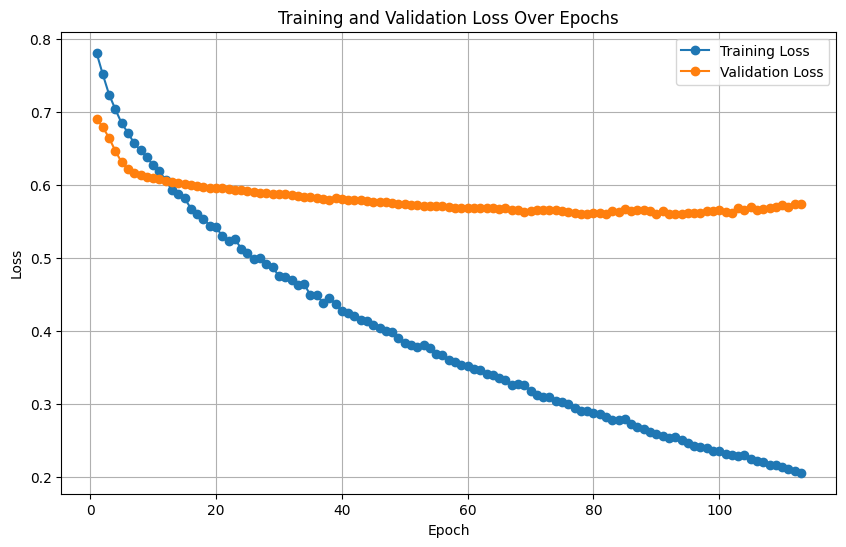

In [49]:
train_model(model, criterion, optimizer, train_loader, val_loader, device, 1000)

Accuracy: 0.7534
F1 Score: 0.7599
Precision: 0.7500
Recall: 0.7701


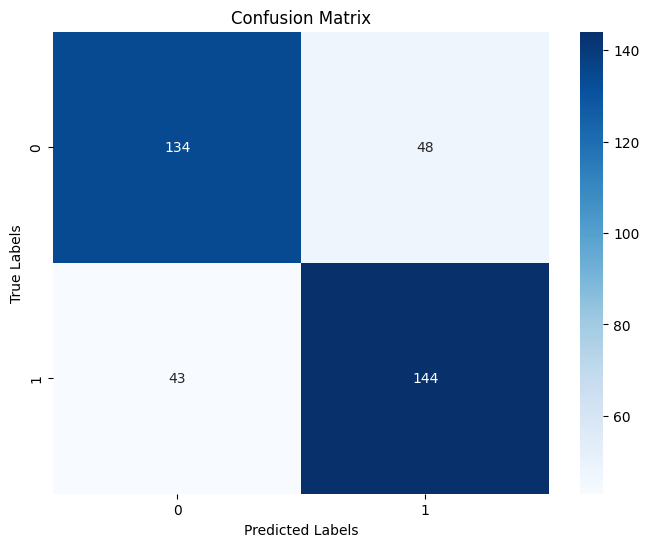

In [50]:
## Testing
with torch.no_grad():
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    outputs = model(x_test_tensor)
    predictions = (outputs > 0.5).float()

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate metrics
accuracy = accuracy_score(y_test, predictions.cpu().numpy())
f1 = f1_score(y_test, predictions.cpu().numpy())
precision = precision_score(y_test, predictions.cpu().numpy())
recall = recall_score(y_test, predictions.cpu().numpy())
conf_matrix = confusion_matrix(y_test, predictions.cpu().numpy())

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()